In [ ]:
import numpy as np
import torch
import torch.nn as nn
import copy
import matplotlib.pyplot as plt

np.random.seed(112233445)
torch.manual_seed(112233445)

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(MLP, self).__init__()
        layers = []
        
        for layer in range(num_layers):
            if layer == 0:  
                layers.append(nn.Sequential(
                    nn.Linear(input_dim, hidden_dim),
                    nn.ReLU()
                ))
            else:
                layers.append(nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.ReLU()
                ))
        
        self.representation = nn.Sequential(*layers)
        
        self.finetune = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out = self.representation(x)
        out = self.finetune(out)
        return out

In [3]:
input_dim = 8
hidden_dim = 16
output_dim = 1
target_num_layers = 5
strong_num_layers = 8
weak_num_layers = 2
target_mlp = MLP(input_dim, hidden_dim, output_dim, target_num_layers)

In [4]:
print(target_mlp)

MLP(
  (representation): Sequential(
    (0): Sequential(
      (0): Linear(in_features=8, out_features=16, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): ReLU()
    )
  )
  (finetune): Linear(in_features=16, out_features=1, bias=True)
)


<h1> generate data for learning representations

In [5]:
num_train = 2000
var = 500

num_tasks = 10

finetune_task_list = []
for i in range(num_tasks):
    finetune_task_list.append(nn.Linear(hidden_dim, output_dim))

x_list = []
y_list = []

for i, task in enumerate(finetune_task_list):
    x = np.random.normal(0, var, (num_train, input_dim))
    
    target_mlp.finetune = task
    
    with torch.no_grad():
        tensorX = torch.tensor(x, dtype=torch.float32)
        tensorY = target_mlp(tensorX)
        
    x_list.append(x)
    y_list.append(tensorY.numpy())

In [6]:
x_list[0].shape, y_list[0].shape

((2000, 8), (2000, 1))

In [7]:
batch_size = 32
learning_rate = 1e-3
best_mse = -np.inf
num_epochs = 1000

In [8]:
def shuffle(x, y):
    order = np.arange(len(x))
    np.random.shuffle(order)
    return x[order, :], y[order, :]

<h1> obtain strong representation $h_s$

In [9]:
strongMLP = MLP(input_dim, hidden_dim, output_dim, strong_num_layers)
optimizers = torch.optim.AdamW(strongMLP.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    total_loss = 0
    for i, task in enumerate(finetune_task_list):
        
        strongMLP.finetune = copy.deepcopy(task)
        x, y = x_list[i], y_list[i]
        x, y = shuffle(x, y)
        
        for param in strongMLP.finetune.parameters():
            param.requires_grad = False
            
        for i in range(0, len(x), batch_size):
            optimizers.zero_grad()

            batchX = x[i:min(i+batch_size, len(x)), :]
            batchX = torch.tensor(batchX, dtype=torch.float32)

            batchY = y[i:min(i+batch_size, len(y)), :]
            batchY = torch.tensor(batchY, dtype=torch.float32)

            out = strongMLP(batchX)
            loss = nn.MSELoss()(out, batchY)
            total_loss += loss.item()

            loss.backward()
            
            optimizers.step()
    print(f"step {epoch}: loss {total_loss:.5f}", end="\r")


<h1> obtain weak representations $h_{w}$

In [10]:
weakMLP = MLP(input_dim, hidden_dim, output_dim, weak_num_layers)
optimizerw = torch.optim.AdamW(weakMLP.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    total_loss = 0
    for i, task in enumerate(finetune_task_list):
        
        weakMLP.finetune = copy.deepcopy(task)
        x, y = x_list[i], y_list[i]
        x, y = shuffle(x, y)
        
        for param in weakMLP.finetune.parameters():
            param.requires_grad = False
            
        for i in range(0, len(x), batch_size):
            optimizerw.zero_grad()

            batchX = x[i:min(i+batch_size, len(x)), :]
            batchX = torch.tensor(batchX, dtype=torch.float32)

            batchY = y[i:min(i+batch_size, len(y)), :]
            batchY = torch.tensor(batchY, dtype=torch.float32)

            out = weakMLP(batchX)
            loss = nn.MSELoss()(out, batchY)
            total_loss += loss.item()

            loss.backward()
            
            optimizerw.step()
    print(f"step {epoch}: loss {total_loss:.5f}", end="\r")


<h1> construct transfer learning data

In [11]:
transferXList = []
transferYList = []
transferMLPList = []
num_trials = 100

for i in range(num_trials):
    transferMLP = copy.deepcopy(target_mlp)
    transferMLP.finetune = nn.Linear(hidden_dim, output_dim)
    transferX = np.random.normal(0, var, (num_train, input_dim))
    with torch.no_grad():
        tensorTransferX = torch.tensor(transferX, dtype=torch.float32)
        tensorTransferY = transferMLP(tensorTransferX)
    transferY = tensorTransferY.numpy()
    
    transferXList.append(transferX)
    transferYList.append(transferY)
    transferMLPList.append(transferMLP)

<h1> train weak models on transfer data

In [12]:
transferWeakMLP_list = []
transferWeakMLPLossList = []
for i, transferX in enumerate(transferXList):
    print("Transferring to task", i+1)
    transferY = transferYList[i]
    
    transferWeakMLP = copy.deepcopy(weakMLP)
    transferWeakMLP.finetune = nn.Linear(hidden_dim, output_dim)
    
    for param in transferWeakMLP.representation.parameters():
        param.requires_grad = False
    
    optimizerTransferWeakMLP = torch.optim.AdamW(transferWeakMLP.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        transferX, transferY = shuffle(transferX, transferY)
        total_loss = 0
        for i in range(0, len(transferX), batch_size):
            optimizerTransferWeakMLP.zero_grad()

            batchX = transferX[i:min(i+batch_size, len(transferX)), :]
            batchX = torch.tensor(batchX, dtype=torch.float32)

            batchY = transferY[i:min(i+batch_size, len(transferY)), :]
            batchY = torch.tensor(batchY, dtype=torch.float32)

            out = transferWeakMLP(batchX)
            loss = nn.MSELoss()(out, batchY)
            total_loss += loss.item()

            loss.backward()

            optimizerTransferWeakMLP.step()
        print(f"step {epoch}: loss {total_loss:.5f}", end="\r")
    transferWeakMLPLossList.append(total_loss)
    transferWeakMLP_list.append(transferWeakMLP)

Transferring to task 1
Transferring to task 22
Transferring to task 38
Transferring to task 4
Transferring to task 59
Transferring to task 64
Transferring to task 77
Transferring to task 88
Transferring to task 90
Transferring to task 10
Transferring to task 11
Transferring to task 12
Transferring to task 13
Transferring to task 14
Transferring to task 15
Transferring to task 16
Transferring to task 17
Transferring to task 18
Transferring to task 19
Transferring to task 20
Transferring to task 21
Transferring to task 22
Transferring to task 23
Transferring to task 24
Transferring to task 25
Transferring to task 26
Transferring to task 27
Transferring to task 28
Transferring to task 29
Transferring to task 30
Transferring to task 31
Transferring to task 32
Transferring to task 33
Transferring to task 34
Transferring to task 35
Transferring to task 36
Transferring to task 37
Transferring to task 38
Transferring to task 39
Transferring to task 40
Transferring to task 41
Transferring to ta

Text(0.5, 1.0, 'Weak models error on finetuning task')

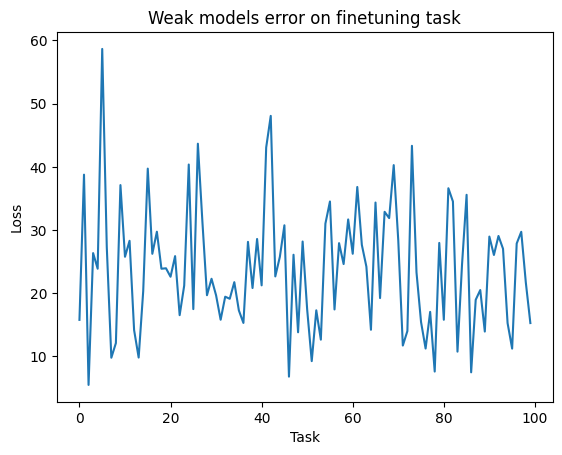

In [13]:
plt.plot(transferWeakMLPLossList)
plt.xlabel("Task")
plt.ylabel("Loss")
plt.title("Weak models error on finetuning task")

<h1> train strong models on transfer data

In [14]:
transferStrongMLP_list = []
transferStrongMLPLossList = []
for i, transferX in enumerate(transferXList):
    print("Transferring to task", i+1)
    transferY = transferYList[i]
    
    transferStrongMLP = copy.deepcopy(strongMLP)
    transferStrongMLP.finetune = nn.Linear(hidden_dim, output_dim)
    
    for param in transferStrongMLP.representation.parameters():
        param.requires_grad = False
    
    optimizerTransferStrongMLP = torch.optim.AdamW(transferStrongMLP.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        transferX, transferY = shuffle(transferX, transferY)
        total_loss = 0
        for i in range(0, len(transferX), batch_size):
            optimizerTransferStrongMLP.zero_grad()

            batchX = transferX[i:min(i+batch_size, len(transferX)), :]
            batchX = torch.tensor(batchX, dtype=torch.float32)

            batchY = transferY[i:min(i+batch_size, len(transferY)), :]
            batchY = torch.tensor(batchY, dtype=torch.float32)

            out = transferStrongMLP(batchX)
            loss = nn.MSELoss()(out, batchY)
            total_loss += loss.item()

            loss.backward()

            optimizerTransferStrongMLP.step()
        print(f"step {epoch}: loss {total_loss:.5f}", end="\r")
    transferStrongMLPLossList.append(total_loss)
    transferStrongMLP_list.append(transferStrongMLP)

Transferring to task 1
Transferring to task 2
Transferring to task 39
Transferring to task 4
Transferring to task 5
Transferring to task 6
Transferring to task 79
Transferring to task 8
Transferring to task 9
Transferring to task 10
Transferring to task 11
Transferring to task 12
Transferring to task 13
Transferring to task 14
Transferring to task 15
Transferring to task 16
Transferring to task 17
Transferring to task 18
Transferring to task 19
Transferring to task 20
Transferring to task 21
Transferring to task 22
Transferring to task 23
Transferring to task 24
Transferring to task 25
Transferring to task 26
Transferring to task 27
Transferring to task 28
Transferring to task 29
Transferring to task 30
Transferring to task 31
Transferring to task 32
Transferring to task 33
Transferring to task 34
Transferring to task 35
Transferring to task 36
Transferring to task 37
Transferring to task 38
Transferring to task 39
Transferring to task 40
Transferring to task 41
Transferring to task 42

Text(0.5, 1.0, 'Strong models error on finetuning task')

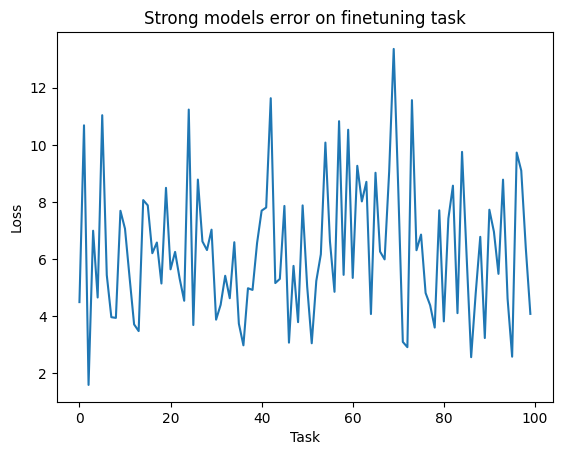

In [15]:
plt.plot(transferStrongMLPLossList)
plt.xlabel("Task")
plt.ylabel("Loss")
plt.title("Strong models error on finetuning task")

<h1> Weak supervision

<h3> Generate weak labels

In [16]:
weakXList = []
weakYList = []

for i, transferWeakMLP in enumerate(transferWeakMLP_list):
    weakX = np.random.normal(0, var, (num_train, input_dim))
    
    weakX = copy.deepcopy(transferXList[i])

    with torch.no_grad():
        tensorWeakX = torch.tensor(weakX, dtype=torch.float32)
        tensorWeakY = transferWeakMLP(tensorWeakX)
        
    weakY = tensorWeakY.numpy() 
    
    weakXList.append(weakX)
    weakYList.append(weakY)

<h3> Train strong model on weakly labeled data

In [17]:
weakStrongMLPList = []
weakStrongLossList = []

for i in range(len(weakXList)):
    
    print("Training strong model on weakly supervised labels on task", i + 1)
    weakX = weakXList[i]
    weakY = weakYList[i]
    
    weakStrongMLP = copy.deepcopy(strongMLP)
    weakStrongMLP.finetune = nn.Linear(hidden_dim, output_dim)
    
    # freeze representation
    for param in weakStrongMLP.representation.parameters():
        param.requires_grad = False
        
    optimizerWeakStrongMLP = torch.optim.AdamW(weakStrongMLP.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        weakX, weakY = shuffle(weakX, weakY)
        total_loss = 0
        for i in range(0, len(weakX), batch_size):
            optimizerWeakStrongMLP.zero_grad()

            batchX = weakX[i:min(i+batch_size, len(weakX)), :]
            batchX = torch.tensor(batchX, dtype=torch.float32)

            batchY = weakY[i:min(i+batch_size, len(weakY)), :]
            batchY = torch.tensor(batchY, dtype=torch.float32)

            out = weakStrongMLP(batchX)
            loss = nn.MSELoss()(out, batchY)
            total_loss += loss.item()

            loss.backward()

            optimizerWeakStrongMLP.step()
        print(f"step {epoch}: loss {total_loss:.5f}", end="\r")
    
    weakStrongLossList.append(total_loss)
    weakStrongMLPList.append(weakStrongMLP)

Training strong model on weakly supervised labels on task 1
Training strong model on weakly supervised labels on task 2
Training strong model on weakly supervised labels on task 3
Training strong model on weakly supervised labels on task 4
Training strong model on weakly supervised labels on task 5
Training strong model on weakly supervised labels on task 6
Training strong model on weakly supervised labels on task 7
Training strong model on weakly supervised labels on task 8
Training strong model on weakly supervised labels on task 9
Training strong model on weakly supervised labels on task 10
Training strong model on weakly supervised labels on task 11
Training strong model on weakly supervised labels on task 12
Training strong model on weakly supervised labels on task 13
Training strong model on weakly supervised labels on task 14
Training strong model on weakly supervised labels on task 15
Training strong model on weakly supervised labels on task 16
Training strong model on weakly s

Text(0.5, 1.0, 'Strong-to-Weak supervision loss')

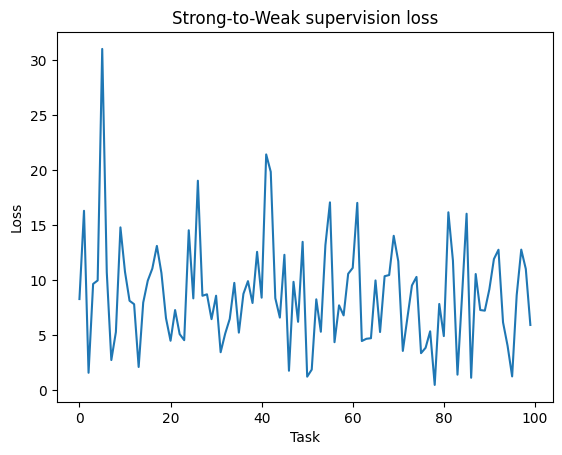

In [18]:
plt.plot(weakStrongLossList)
plt.xlabel("Task")
plt.ylabel("Loss")
plt.title("Strong-to-Weak supervision loss")

<h1> Evaluate

In [19]:
@torch.no_grad()
def evaluate_loss(model, x, y):
    out = model(x)
    return nn.MSELoss()(out, y)

In [20]:
transferWeakMLPLossList = []
weakStrongMLPLossList = []
strongOnWeakLossList = []

for i in range(len(transferWeakMLP_list)):
    transferMLP = transferMLPList[i]
    transferWeakMLP = transferWeakMLP_list[i]
    weakStrongMLP = weakStrongMLPList[i]
    
    transferX = np.random.normal(0, var, (num_train, input_dim))
    with torch.no_grad():
        tensorTransferX = torch.tensor(transferX, dtype=torch.float32)
        tensorTransferY = transferMLP(tensorTransferX)
    
    transferWeakMLPLoss = evaluate_loss(transferWeakMLP, tensorTransferX, tensorTransferY)
    weakStrongMLPLoss = evaluate_loss(weakStrongMLP, tensorTransferX, tensorTransferY)
    
    weakX = np.random.normal(0, var, (num_train, input_dim))

    with torch.no_grad():
        tensorWeakX = torch.tensor(weakX, dtype=torch.float32)
        tensorWeakY = transferWeakMLP(tensorWeakX)
    
    strongOnWeakLoss = evaluate_loss(weakStrongMLP, tensorWeakX, tensorWeakY)
    
    transferWeakMLPLossList.append(transferWeakMLPLoss)
    weakStrongMLPLossList.append(weakStrongMLPLoss)
    strongOnWeakLossList.append(strongOnWeakLoss)

Text(0, 0.5, 'Loss on weakly supervised data')

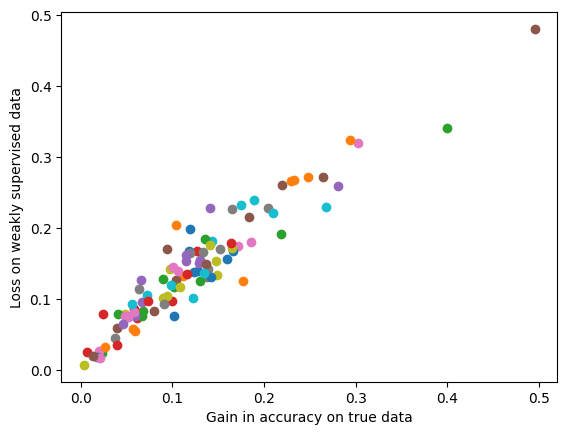

In [21]:
gainList = np.array(transferWeakMLPLossList) - np.array(weakStrongMLPLossList)

for i in range(len(strongOnWeakLossList)):
    plt.scatter(gainList[i], strongOnWeakLossList[i])

plt.xlabel("Gain in accuracy on true data")
plt.ylabel("Loss on weakly supervised data")